In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [58]:
df = pd.read_csv("Spotify Youtube Dataset.csv")

In [59]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

Eksik Veri Analizi Görseli


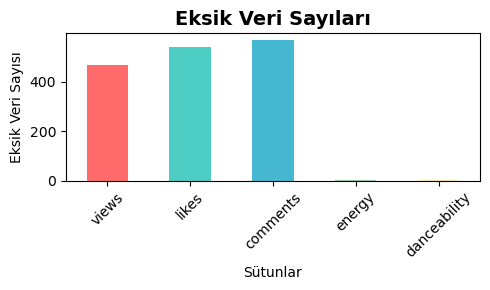

In [60]:
# GÖRSEL 1: Eksik Veri Analizi
print("Eksik Veri Analizi Görseli")
eksik_veri = df[['views', 'likes', 'comments', 'energy', 'danceability']].isnull().sum()

plt.figure(figsize=(5, 3))
eksik_veri.plot(kind = 'bar', color = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
plt.title('Eksik Veri Sayıları', fontsize = 14, fontweight = 'bold')
plt.xlabel('Sütunlar')
plt.ylabel('Eksik Veri Sayısı')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [61]:
print(f"Veri Boyutu: {df.shape[0]} Satır, {df.shape[1]} Sütun")

print("Eksik Veri Sayıları:")
print(f"Views: {df['views'].isnull().sum()}")
print(f"Likes: {df['likes'].isnull().sum()}")
print(f"Comments: {df['comments'].isnull().sum()}")

Veri Boyutu: 20718 Satır, 28 Sütun
Eksik Veri Sayıları:
Views: 470
Likes: 541
Comments: 569


In [62]:
df['likes'] = df['likes'].fillna(0)
df['comments'] = df['comments'].fillna(0)
df['stream'] = df['stream'].fillna(df['stream'].median())


In [63]:
df = df.dropna(subset = ['views'])

print(f"Temizlik Sonrası Veri Boyutu: {df.shape[0]} Satır")

Temizlik Sonrası Veri Boyutu: 20248 Satır


In [64]:
viral_sinir = 10_000_000
df['viral'] = (df['views'] > viral_sinir).astype(int)

In [65]:
viral_sayisi = df['viral'].sum()
toplam_video = len(df)
viral_yuzde = (viral_sayisi / toplam_video) * 100

print(f"Viral Sınır: {viral_sinir:,} İzlenme")
print(f"Viral Video Sayısı: {viral_sayisi}")
print(f"Toplam Video: {toplam_video}")
print(f"Viral Oranı: %{viral_yuzde:.1f}")

Viral Sınır: 10,000,000 İzlenme
Viral Video Sayısı: 11218
Toplam Video: 20248
Viral Oranı: %55.4


Viral Video Dağılımı


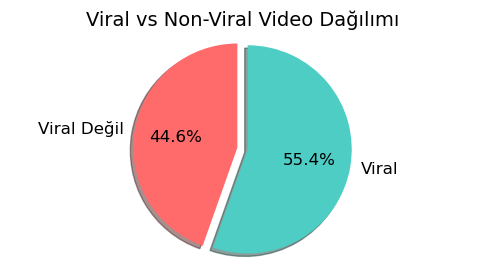

In [66]:
# GÖRSEL 2: Viral Dağılımı (Pasta Grafik)
print("Viral Video Dağılımı")
plt.figure(figsize = (6, 3))
labels = ['Viral Değil', 'Viral']
sizes = [toplam_video - viral_sayisi, viral_sayisi]
colors = ['#FF6B6B', '#4ECDC4']
explode = (0, 0.1)

plt.pie(sizes, labels = labels, colors = colors, explode = explode, autopct = '%1.1f%%', 
        shadow = True, startangle = 90, textprops = {'fontsize': 12})
plt.title('Viral vs Non-Viral Video Dağılımı', fontsize = 14)
plt.axis('equal')
plt.show()


In [67]:
# Feature Engineering

# YouTube Engagement Özellikleri
df['like_rate'] = df['likes'] / df['views']
df['comment_oranı'] = df['comments'] / df['views']
df['engagement_oranı'] = (df['likes'] + df['comments']) / df['views']

# Spotify Müzik Özellikleri Kombinasyonları
df['energy_valence_score'] = df['energy'] * df['valence']  # Enerji × Mutluluk
df['danceability_energy_index'] = df['danceability'] * df['energy']  # Dans × Enerji

# Sonsuz Değerleri Temizle (0'A Bölme Hatası)
df = df.replace([np.inf, -np.inf], 0)



📊 Oluşturulan Özelliklerin Dağılımı


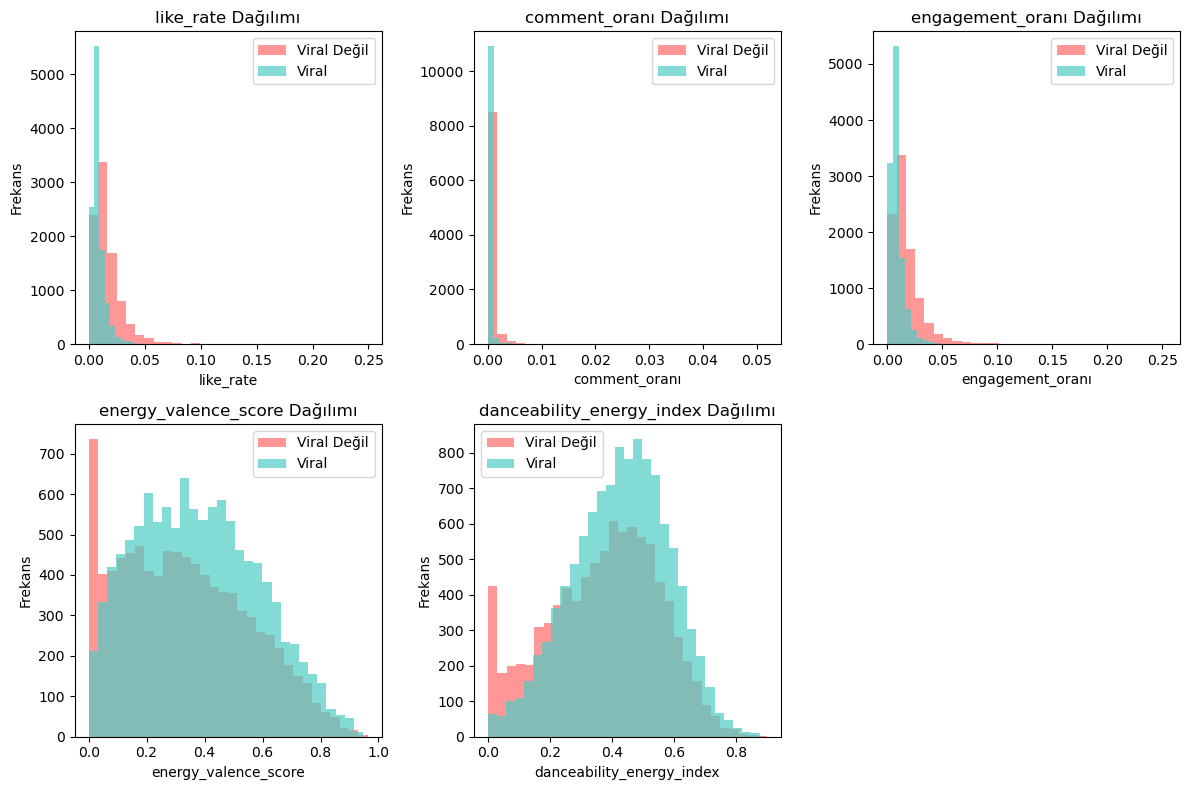

In [ ]:
# GÖRSEL 3: Feature Engineering Sonrası Dağılımlar
print("\n📊 Oluşturulan Özelliklerin Dağılımı")
new_features = ['like_rate', 'comment_oranı', 'engagement_oranı', 'energy_valence_score', 'danceability_energy_index']

plt.figure(figsize = (12, 8))
for i, feature in enumerate(new_features, 1):
    plt.subplot(2, 3, i)
    
    # Viral ve Non-Viral İçin Ayrı Histogramlar
    viral_data = df[df['viral'] == 1][feature]
    non_viral_data = df[df['viral'] == 0][feature]
    
    plt.hist(non_viral_data, bins = 30, alpha = 0.7, label = 'Viral Değil', color = '#FF6B6B')
    plt.hist(viral_data, bins = 30, alpha = 0.7, label = 'Viral', color = '#4ECDC4')
    plt.title(f'{feature} Dağılımı')
    plt.xlabel(feature)
    plt.ylabel('Frekans')
    plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Kullanacağımız Özellikleri Seç

# VIEWS'İ KULLANMIYORUZ! (Bu önemli - Data Leakage Olmasın)
secilen_ozellikler = [
    # YouTube Etkileşim Özellikleri
    'like_rate', 'comment_oranı', 'engagement_oranı',
    
    # Spotify Müzik Özellikleri
    'danceability', 'energy', 'valence', 'acousticness',
    'tempo', 'loudness', 'duration_ms',
    
    # Yeni Oluşturduğumuz Özellikler
    'energy_valence_score', 'danceability_energy_index'
]

In [70]:
# Veriyi Hazırla (X ve y)

df_temiz = df.dropna(subset=secilen_ozellikler + ['viral'])

X = df_temiz[secilen_ozellikler]
y = df_temiz['viral']

print(f"X Boyutu: {X.shape}")
print(f"y Boyutu: {y.shape}")
print(f"Viral Oranı: %{y.mean()*100:.1f}")

X Boyutu: (20246, 12)
y Boyutu: (20246,)
Viral Oranı: %55.4


In [71]:
# Özellikleri Standartlaştır

# StandardScaler ile özellikleri 0-1 arasına getir.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

print(f"Eğitim Seti: {X_train.shape[0]} Video")
print(f"Test Seti: {X_test.shape[0]} Video")
print(f"Eğitim Viral Oranı: %{y_train.mean()*100:.1f}")
print(f"Test Viral Oranı: %{y_test.mean()*100:.1f}")

Eğitim Seti: 16196 Video
Test Seti: 4050 Video
Eğitim Viral Oranı: %55.4
Test Viral Oranı: %55.4


In [73]:
# Random Forest Modeli
model = RandomForestClassifier(
    n_estimators = 100,
    random_state = 42,
    max_depth = 10
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:
# Tahmin Yap ve Değerlendir
y_pred = model.predict(X_test)

dogruluk = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: %{dogruluk*100:.1f}")



Model Doğruluğu: %75.0


In [75]:
# Confusion Matrix (Karışıklık Matrisi)
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:")
print(f"Doğru Viral Değil: {cm[0,0]}")
print(f"Yanlış Viral: {cm[0,1]}")  
print(f"Yanlış Viral Değil: {cm[1,0]}")
print(f"Doğru Viral: {cm[1,1]}")

Karışıklık Matrisi:
Doğru Viral Değil: 1243
Yanlış Viral: 563
Yanlış Viral Değil: 448
Doğru Viral: 1796


In [76]:
# Classification Report
print(f"\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=['Viral Değil', 'Viral']))


Sınıflandırma Raporu:
              precision    recall  f1-score   support

 Viral Değil       0.74      0.69      0.71      1806
       Viral       0.76      0.80      0.78      2244

    accuracy                           0.75      4050
   macro avg       0.75      0.74      0.75      4050
weighted avg       0.75      0.75      0.75      4050



In [77]:
# Feature Importanceları Al
onemlilik = model.feature_importances_

onemli_ozellikler = pd.DataFrame({
    'ozellik': X.columns,
    'onemlilik': onemlilik
}).sort_values('onemlilik', ascending = False)

print("En Önemli 3 Özellik:")
print("=" * 25)
for i in range(min(3, len(onemli_ozellikler))):
    ozellik = onemli_ozellikler.iloc[i]['ozellik']
    onem = onemli_ozellikler.iloc[i]['onemlilik']
    print(f"{i+1}. {ozellik}: {onem:.3f}")

En Önemli 3 Özellik:
1. engagement_oranı: 0.221
2. like_rate: 0.196
3. comment_oranı: 0.160


Feature Importance Görseli


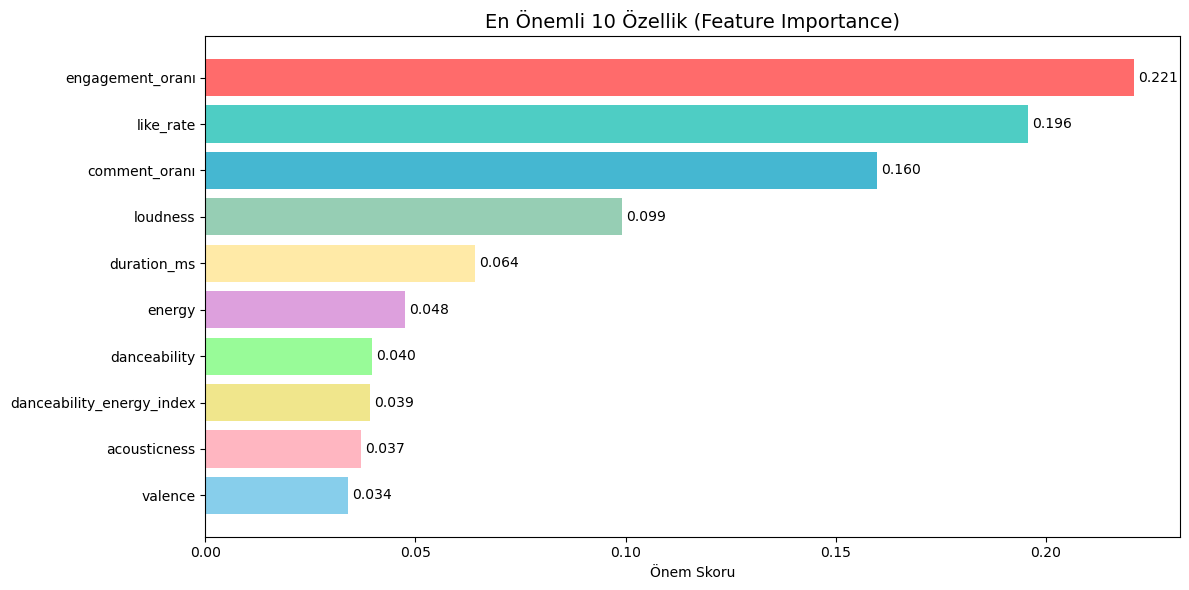

In [ ]:
# GÖRSEL 3: Feature Importance
print("Feature Importance Görseli")
plt.figure(figsize = (12, 6))

top_features = onemli_ozellikler.head(10)

# Yatay Bar Chart
bars = plt.barh(range(len(top_features)), top_features['onemlilik'], 
                color = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', 
                       '#DDA0DD', '#98FB98', '#F0E68C', '#FFB6C1', '#87CEEB'])

plt.yticks(range(len(top_features)), top_features['ozellik'])
plt.xlabel('Önem Skoru')
plt.title('En Önemli 10 Özellik (Feature Importance)', fontsize = 14)
plt.gca().invert_yaxis()  # En önemli özellik üstte olsun.


for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha = 'left', va = 'center')

plt.tight_layout()
plt.show()

Model Performans Özeti


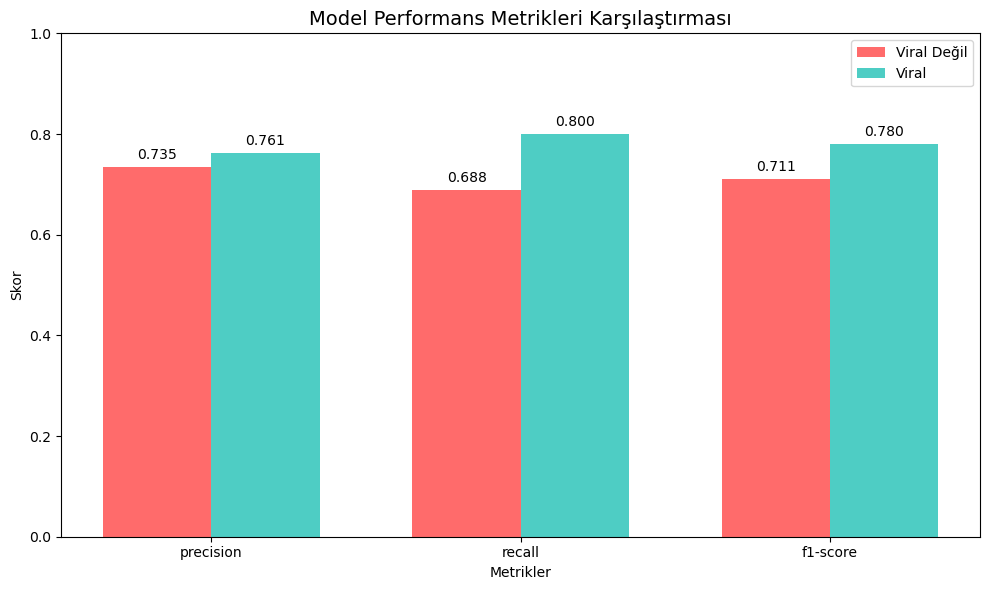

In [ ]:
# GÖRSEL 4: Model Performans Özeti
print("Model Performans Özeti")
classification_rep = classification_report(y_test, y_pred, target_names=['Viral Değil', 'Viral'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
viral_degil = [classification_rep['Viral Değil'][metric] for metric in metrics]
viral = [classification_rep['Viral'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize = (10, 6))
plt.bar(x - width/2, viral_degil, width, label = 'Viral Değil', color = '#FF6B6B')
plt.bar(x + width/2, viral, width, label = 'Viral', color = '#4ECDC4')

plt.xlabel('Metrikler')
plt.ylabel('Skor')
plt.title('Model Performans Metrikleri Karşılaştırması', fontsize = 14)
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

for i, (v1, v2) in enumerate(zip(viral_degil, viral)):
    plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha = 'center', va = 'bottom')
    plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()

In [80]:
# SONUÇ
print(f"\n" + "=" * 50)
print("PROJE SONUCU")
print("=" * 50)

print(f"✅ Model Doğruluğu: %{dogruluk*100:.1f}")
print(f"✅ {X_test.shape[0]} Video Uzerinde Test Edildi")

if dogruluk > 0.8:
    print("Başarılı!")
elif dogruluk > 0.7:
    print("İyi!")
elif dogruluk > 0.6:
    print("Geliştirilmesi Mümkün!")
else:
    print("Düşük Performans!")



PROJE SONUCU
✅ Model Doğruluğu: %75.0
✅ 4050 Video Uzerinde Test Edildi
İyi!
